### Dependencies

In [1]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Loading Data

Dataset: https://www.kaggle.com/datasets/ninadaithal/imagesoasis

In [2]:
# Create your DataFrame
images = []
labels = []
for subfolder in tqdm(os.listdir(r'C:\Users\rohan\Desktop\184a\AD-Detection\archive')):
    subfolder_path = os.path.join(r'C:\Users\rohan\Desktop\184a\AD-Detection\archive', subfolder)
    label = 0
    for folder in os.listdir(subfolder_path):
        subfolder_path2 = os.path.join(subfolder_path, folder)
        scan = []
        img_num = 0
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            scan.append(image_path)
            img_num += 1
            if img_num > 60:
                images.append(scan)
                if label == 2: # modded for binary classification
                    labels.append(0)
                else:
                    labels.append(1)
                img_num = 0
                scan = []
        label += 1

df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


,image,label
0,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
1,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
2,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
3,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
4,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
...,...,...
1412,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
1413,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
1414,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1
1415,[C:\Users\rohan\Desktop\184a\AD-Detection\arch...,1


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], shuffle=True, random_state=42)

In [4]:
class ADDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths (as lists) and labels.
            transform (callable, optional): Optional transform to be applied on images.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the list of image paths and the label
        img_paths = self.dataframe.iloc[idx, 0]  # List of 61 image paths
        label = self.dataframe.iloc[idx, 1]

        # Load and process all images in the list
        images = []
        for img_path in img_paths:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)

        # Stack the images into a tensor of shape (61, C, H, W)
        images = torch.stack(images)  # Shape: (61, C, H, W)
        label = torch.tensor(label, dtype=torch.long)

        return images, label


# Define transformations for each image
transform = transforms.Compose([
    transforms.Resize((176, 176)),  # Resize all images to 176x176
    transforms.ToTensor(),         # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [5]:
# Create Datasets for training and testing
train_dataset = ADDataset(train_df, transform=transform)
test_dataset = ADDataset(test_df, transform=transform)

print(len(train_dataset), len(test_dataset))


# Create DataLoaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Test the DataLoader
print("Training DataLoader:")
for images, labels in train_dataloader:
    print(images.shape)  # Should be [batch_size, 3, 176, 176]
    print(labels)        # Corresponding labels
    break

print("Testing DataLoader:")
for images, labels in test_dataloader:
    print(images.shape)  # Should be [batch_size, 3, 176, 176]
    print(labels)        # Corresponding labels
    break

1133 284
Training DataLoader:
torch.Size([8, 61, 3, 176, 176])
tensor([1, 0, 1, 1, 0, 0, 1, 0])
Testing DataLoader:
torch.Size([8, 61, 3, 176, 176])
tensor([1, 0, 0, 0, 0, 0, 1, 0])


### CNN with Feature Extraction Blocks (Inspired by DEMNET)

In [6]:
class FeatureExtractionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureExtractionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batch_norm(x)
        x = self.max_pool(x)
        return x


class ADCNN(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(ADCNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            FeatureExtractionBlock(16, 32),  # Output: 32 channels
            FeatureExtractionBlock(32, 64),  # Output: 64 channels
            FeatureExtractionBlock(64, 128),  # Output: 128 channels
            FeatureExtractionBlock(128, 256),  # Output: 256 channels
        )

        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64) 
        self.fc4 = nn.Linear(64, 2)
        
    def forward(self, x):
        # Input: (batch_size, 61, 3, 176, 176)
        batch_size, seq_len, channels, height, width = x.shape

        # Flatten temporal dimension and process each image
        x = x.view(batch_size * seq_len, channels, height, width)  # Shape: (batch_size * 61, 3, 176, 176)
        x = self.feature_extractor(x)  # Extract features: Shape (batch_size * 61, 256, 5, 5)

        # Flatten the spatial dimensions
        x = torch.flatten(x, start_dim=1)  # Shape: (batch_size * 61, 256 * 5 * 5)

        # Reshape to (batch_size, seq_len, -1) for aggregation
        x = x.view(batch_size, seq_len, -1)  # Shape: (batch_size, 61, 256 * 5 * 5)

        # Aggregate features across the sequence dimension
        x = torch.mean(x, dim=1)  # Shape: (batch_size, 256 * 5 * 5)

        # Fully connected layers
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # Final output: (batch_size, 4)

        return x


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = ADCNN()

cuda:0


### Training

In [10]:

for inputs, labels in train_dataloader:
    print(inputs.shape, labels.shape)
    break

def train_model(model, train_loader, num_epochs=20, learning_rate=0.001, device='cuda'):
    # Move model to the selected device (GPU or CPU)
    model.to(device)
    
    # Initialize RMSprop optimizer
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    # Loss function (CrossEntropy for classification)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to the selected device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass (backpropagation)
            loss.backward()

            # Update weights
            optimizer.step()

            # Track running loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print stats for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        if epoch % 5 == 0:
            torch.save(model.state_dict(), r'C:\Users\rohan\Desktop\184a\AD-Detection\trained.pth')
     
    print('Training Finished!')


train_model(model, train_dataloader , num_epochs=20, learning_rate=0.001, device='cuda')
torch.save(model.state_dict(), r'C:\Users\rohan\Desktop\184a\AD-Detection\trained.pth')

torch.Size([8, 61, 3, 176, 176]) torch.Size([8])
Epoch [1/50], Loss: 0.4877, Accuracy: 78.46%
Epoch [2/50], Loss: 0.4262, Accuracy: 78.55%
Epoch [3/50], Loss: 0.3349, Accuracy: 84.02%
Epoch [4/50], Loss: 0.3340, Accuracy: 82.61%
Epoch [5/50], Loss: 0.3176, Accuracy: 83.85%
Epoch [6/50], Loss: 0.3104, Accuracy: 83.58%
Epoch [7/50], Loss: 0.2966, Accuracy: 85.35%
Epoch [8/50], Loss: 0.2591, Accuracy: 87.64%
Epoch [9/50], Loss: 0.2956, Accuracy: 85.97%
Epoch [10/50], Loss: 0.2625, Accuracy: 86.41%
Epoch [11/50], Loss: 0.2455, Accuracy: 88.35%
Epoch [12/50], Loss: 0.2155, Accuracy: 89.85%
Epoch [13/50], Loss: 0.1674, Accuracy: 92.59%
Epoch [14/50], Loss: 0.2016, Accuracy: 91.79%
Epoch [15/50], Loss: 0.1764, Accuracy: 94.00%
Epoch [16/50], Loss: 0.0959, Accuracy: 96.91%
Epoch [17/50], Loss: 0.0893, Accuracy: 96.20%
Epoch [18/50], Loss: 0.1460, Accuracy: 96.91%
Epoch [19/50], Loss: 0.0681, Accuracy: 97.71%
Epoch [20/50], Loss: 0.0387, Accuracy: 98.41%
Epoch [21/50], Loss: 0.0635, Accuracy: 9

KeyboardInterrupt: 

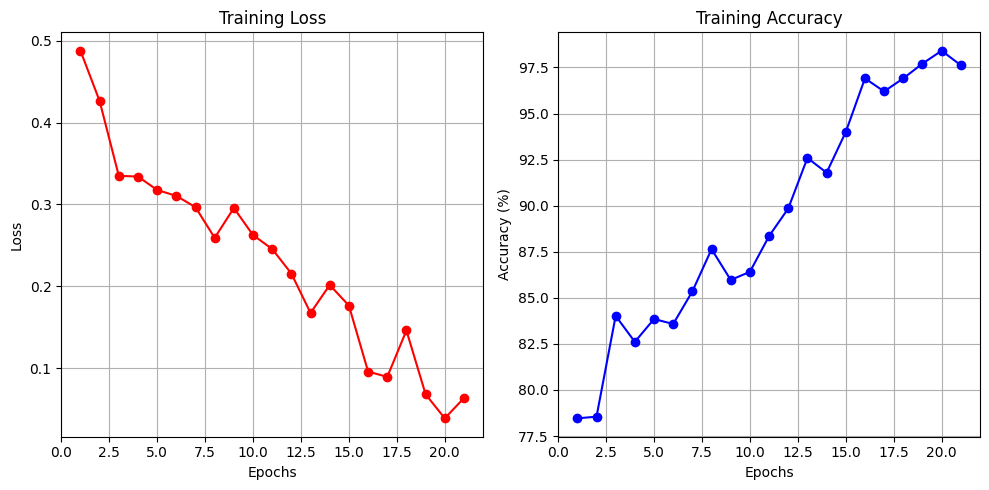

In [13]:
import matplotlib.pyplot as plt

# Corrected Training data from your log 
epochs = list(range(1, 22))  # Using 21 epochs
losses = [
    0.4877, 0.4262, 0.3349, 0.3340, 0.3176, 0.3104, 0.2966, 0.2591, 0.2956, 0.2625,
    0.2455, 0.2155, 0.1674, 0.2016, 0.1764, 0.0959, 0.0893, 0.1460, 0.0681, 0.0387, 0.0635
]
accuracies = [
    78.46, 78.55, 84.02, 82.61, 83.85, 83.58, 85.35, 87.64, 85.97, 86.41,
    88.35, 89.85, 92.59, 91.79, 94.00, 96.91, 96.20, 96.91, 97.71, 98.41, 97.62
]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Loss', color='red', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Accuracy', color='blue', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), r'C:\Users\rohan\Desktop\184a\AD-Detection\trained.pth')

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ADCNN().to(device)
model.load_state_dict(torch.load(r'C:\Users\rohan\Desktop\184a\AD-Detection\trained.pth'))

C:\Users\rohan\AppData\Local\Temp\ipykernel_16876\237112544.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\rohan\Desktop\184

<All keys matched successfully>

### Evaluating

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import itertools
import torch

for inputs, labels in test_dataloader:
    print(inputs.shape, labels.shape)
    break

def evaluate_model(model, test_loader, device='cuda'):
    y_pred_list = []
    y_target_list = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient calculations needed
        for inputs, labels in test_loader:
            # Move data to the selected device
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, y_pred = torch.max(outputs, 1)  # Predicted labels
            
            y_pred_list.append(y_pred.cpu().numpy())  # Move to CPU for metrics
            y_target_list.append(labels.cpu().numpy())  # Move to CPU for metrics

    # Flatten the predictions and targets
    y_pred_list = list(itertools.chain.from_iterable(y_pred_list))
    y_target_list = list(itertools.chain.from_iterable(y_target_list))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_target_list, y_pred_list)
    print("Confusion Matrix of the Test Set")
    print("-----------")
    print(conf_matrix)

    # Calculate metrics
    precision = precision_score(y_target_list, y_pred_list, average='weighted')
    recall = recall_score(y_target_list, y_pred_list, average='weighted')
    f1 = f1_score(y_target_list, y_pred_list, average='weighted')

    print(f"Precision of the Model :\t{precision:.4f}")
    print(f"Recall of the Model    :\t{recall:.4f}")
    print(f"F1 Score of the Model  :\t{f1:.4f}")

# Call the evaluation function
evaluate_model(model, test_dataloader, device='cuda')


torch.Size([8, 61, 3, 176, 176]) torch.Size([8])
Confusion Matrix of the Test Set
-----------
[[220   1]
 [ 35  28]]
Precision of the Model :	0.8855
Recall of the Model    :	0.8732
F1 Score of the Model  :	0.8543
